## Clasificación

In [58]:
# Librerias
import time
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
import wandb

In [13]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zerocris (zerocris13) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
# Dataset
df = pd.read_csv("Grisoni_et_al_2016_EnvInt88.csv") 
print(df.describe())

              nHM      piPC09         PCD        X2Av       MLOGP        ON1V  \
count  779.000000  779.000000  779.000000  779.000000  779.000000  779.000000   
mean     1.754814    3.467616    1.550822    0.236881    3.201746    1.510295   
std      1.985866    2.983778    0.958708    0.149319    1.595702    0.834753   
min      0.000000    0.000000    0.000000    0.090000   -1.960000    0.080000   
25%      0.000000    0.000000    1.210000    0.170000    2.190000    0.910000   
50%      1.000000    4.263000    1.400000    0.200000    3.130000    1.270000   
75%      3.000000    6.250000    2.285000    0.240000    4.235000    2.020000   
max     12.000000    9.316000    5.900000    2.230000    8.320000    7.190000   

            N-072    B02[C-N]    F04[C-O]       Class      logBCF  
count  779.000000  779.000000  779.000000  779.000000  779.000000  
mean     0.186136    0.423620    3.585366    1.736842    2.062773  
std      0.501937    0.494449    4.430421    0.921782    1.351290 

In [15]:
df["Class"] = df["Class"].astype(int) - 1  # convertir a 0,1,2

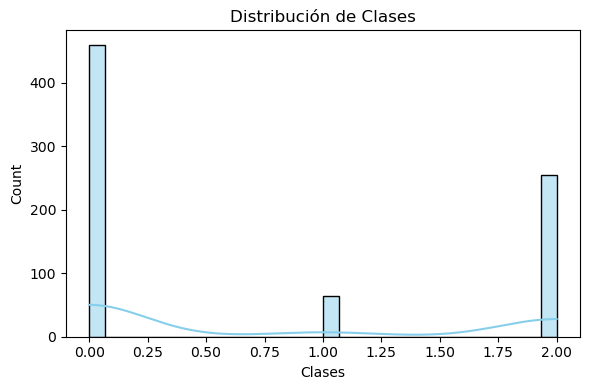

In [16]:
# Target
plt.figure(figsize=(6, 4))
sns.histplot(df["Class"], kde=True, bins=30, color="skyblue")
plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.tight_layout()
plt.show()

Notar el desbalance de clase

In [112]:
X = df.drop(columns=["CAS", "SMILES", "Set", "logBCF", "Class"])
y = df["Class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_trainval = X_scaled[df["Set"] == "Train"]
y_trainval = y[df["Set"] == "Train"]
X_test = X_scaled[df["Set"] == "Test"]
y_test = y[df["Set"] == "Test"]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=13, stratify=y_trainval
)

# Tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [158]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.net(x)

model = Net(input_dim=X_train.shape[1])

In [159]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=20):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            alpha_factor = self.alpha.gather(0, targets)
            loss = alpha_factor * (1 - pt) ** self.gamma * ce_loss
        else:
            loss = (1 - pt) ** self.gamma * ce_loss
        return loss.mean()


In [160]:
import torch.nn.functional as F

class FocalLossWithLabelSmoothing(nn.Module):
    def __init__(self, alpha=None, gamma=2, smoothing=0.1, n_classes=3):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.n_classes = n_classes

    def smooth_labels(self, target):
        with torch.no_grad():
            true_dist = torch.zeros(size=(target.size(0), self.n_classes), device=target.device)
            true_dist.fill_(self.smoothing / (self.n_classes))
            true_dist.scatter_(1, target.unsqueeze(1), 1 - self.smoothing)
        return true_dist

    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        log_prob = F.log_softmax(logits, dim=1)
        smoothed_target = self.smooth_labels(target)

        # focal term
        focal_term = (1 - prob) ** self.gamma

        if self.alpha is not None:
            alpha = self.alpha.to(logits.device)
            focal_term = alpha.unsqueeze(0) * focal_term  # broadcast α

        loss = -smoothed_target * focal_term * log_prob
        return loss.sum(dim=1).mean()


In [161]:
from collections import Counter

cnt = Counter(y_train)
alpha = torch.tensor([1 / cnt[c] for c in sorted(cnt)], dtype=torch.float32)

criterion = FocalLossWithLabelSmoothing(
    alpha=alpha,
    gamma=2,
    smoothing=0.1,
    n_classes=3
)



In [162]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 60
patience = 300
best_val_loss = float('inf')
counter = 0
start_time = time.time()

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')  # o relu
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)


wandb.init(project="ch6_classification", entity="zerocris13")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            wandb.log({f"gradients/{name}": param.grad.norm().item()})

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
    
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": loss.item(),
        "val_loss": val_loss.item()
    })    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

elapsed = time.time() - start_time

Epoch 1, Train Loss: 0.0074, Val Loss: 0.0137
Epoch 2, Train Loss: 0.0069, Val Loss: 0.0118
Epoch 3, Train Loss: 0.0072, Val Loss: 0.0103
Epoch 4, Train Loss: 0.0060, Val Loss: 0.0092
Epoch 5, Train Loss: 0.0073, Val Loss: 0.0082
Epoch 6, Train Loss: 0.0060, Val Loss: 0.0074
Epoch 7, Train Loss: 0.0059, Val Loss: 0.0068
Epoch 8, Train Loss: 0.0057, Val Loss: 0.0063
Epoch 9, Train Loss: 0.0056, Val Loss: 0.0059
Epoch 10, Train Loss: 0.0052, Val Loss: 0.0055
Epoch 11, Train Loss: 0.0053, Val Loss: 0.0052
Epoch 12, Train Loss: 0.0053, Val Loss: 0.0049
Epoch 13, Train Loss: 0.0052, Val Loss: 0.0047
Epoch 14, Train Loss: 0.0050, Val Loss: 0.0044
Epoch 15, Train Loss: 0.0051, Val Loss: 0.0043
Epoch 16, Train Loss: 0.0049, Val Loss: 0.0041
Epoch 17, Train Loss: 0.0048, Val Loss: 0.0040
Epoch 18, Train Loss: 0.0047, Val Loss: 0.0039
Epoch 19, Train Loss: 0.0044, Val Loss: 0.0038
Epoch 20, Train Loss: 0.0045, Val Loss: 0.0037
Epoch 21, Train Loss: 0.0047, Val Loss: 0.0036
Epoch 22, Train Loss: 


Classification Report:
               precision    recall  f1-score   support

           0     0.7308    0.4957    0.5907       115
           1     0.1695    0.6250    0.2667        16
           2     0.5000    0.4531    0.4754        64

    accuracy                         0.4923       195
   macro avg     0.4668    0.5246    0.4443       195
weighted avg     0.6090    0.4923    0.5263       195



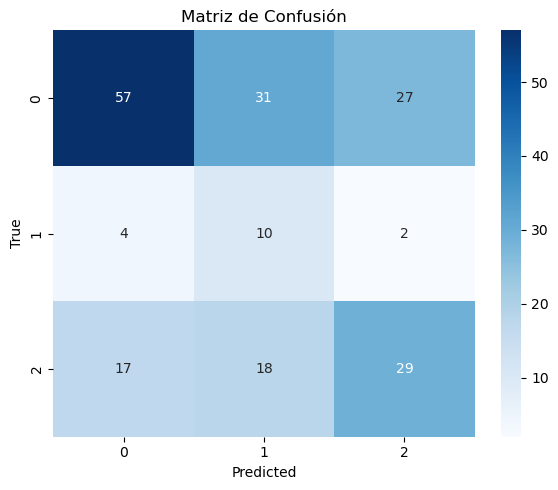

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
gradients/net.0.bias,▅▅▅▅▇█▅▃▃▄▅▃▃▂▂▂▃▂▂▂▂▂▂▃▂▂▁▂▂▁▂▂▁▂▂▁▂▂▁▁
gradients/net.0.weight,██▇█▆▄▅▅▆▅▃▄▃▂▃▂▂▃▂▂▂▂▁▂▁▂▂▂▁▂▁▁▂▂▁▁▂▁▁▁
gradients/net.1.bias,█▆▇▅▅▄▄▃▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁
gradients/net.1.weight,█▇▆█▆▅▄▄▅▄▄▄▄▃▃▂▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▁▁▁▁▂▁
gradients/net.4.bias,█▇▅█▆▅▄▄▅▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▂▁▁▁▂▂
gradients/net.4.weight,█▇▇▇▆▅▄▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▃▃▂▂▂▂▂▁▂▁▁▂▁▂▁▁
gradients/net.5.bias,█▇▇▆▆▆▄▄▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
gradients/net.5.weight,▇█▆█▆▆▆▅▄▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▂▁▁▂▁
gradients/net.8.bias,███▇▇▆▆▅▅▅▄▄▄▃▃▁▂▁▁▁▁▁▁▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁
gradients/net.8.weight,█▇▇▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁


In [163]:
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_pred_labels = y_test_pred.argmax(dim=1).numpy()
    
acc = accuracy_score(y_test, y_pred_labels)
f1_weighted = f1_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')

# Clasificación por clase
report = classification_report(y_test, y_pred_labels, digits=4)
print("\nClassification Report:\n", report)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title("Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

wandb.log({"test_acc": acc, "test_f1_weighted": f1_weighted, "test_precision": precision, "test_recall": recall,})
wandb.finish()

Se compararon múltiples configuraciones para la clasificación de mecanismos de bioconcentración, destacando como mejor modelo a `stellar-sweep-1`, que presentó las mejores métricas en *test accuracy*, *F1 ponderado*, *precision* y *recall*. Este modelo utilizó una arquitectura de 2 capas con 64 unidades ocultas y un tiempo de entrenamiento de **17.776 segundos**, lo cual sugiere que una red menos profunda y compacta fue más adecuada para este problema. En contraste, `clean-sweep-2` fue el peor modelo evaluado, con 3 capas y 128 unidades (tiempo de entrenamiento: **14.364 segundos**), lo que podría haber inducido sobreajuste, especialmente considerando el reducido tamaño y desbalance de clases en el dataset.

A pesar del uso de técnicas robustas como normalización por lotes (*BatchNorm*), regularización con *Dropout*, *Focal Loss* y *label smoothing*, las métricas globales no fueron altas. Esto evidencia una limitación intrínseca del conjunto de datos. Se recomienda explorar modelos clásicos de *machine learning* (como *Random Forest* o *SVM*), los cuales suelen ser más eficientes con pocos datos, o bien ampliar el dataset e incluir técnicas de aumento sintético.

🔗 [Visualizar resultados en W&B](https://api.wandb.ai/links/zerocris13/3uvjgs8i)
